<a href="https://colab.research.google.com/github/Liso15/Projects/blob/main/GBP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import data
# Import warnings and add a filter to ignore them
import warnings
warnings.simplefilter('ignore')
# Import XGBoost
import xgboost
# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns
# For data manipulation
import pandas as pd
import numpy as np
import os

In [ ]:
pwd = os.getcwd()

In [ ]:
# function for loading the data file

df = pd.read_csv(pwd + "/GBP.csv",index_col=[0], parse_dates=[0])
df

,GBP/USD Close
Date,
1998-12-31,88.67
1999-01-01,88.67
1999-01-04,85.60
1999-01-05,83.95
1999-01-06,86.96
...,...
2018-07-12,48.59
2018-07-13,48.56
2018-07-16,48.56


In [ ]:
df.head()

,GBP/USD Close
Date,
1998-12-31,88.67
1999-01-01,88.67
1999-01-04,85.60
1999-01-05,83.95
1999-01-06,86.96


In [ ]:
df.tail()

,GBP/USD Close
Date,
2018-07-12,48.59
2018-07-13,48.56
2018-07-16,48.56
2018-07-17,48.08
2018-07-18,47.40


EDA

Palette

In [ ]:
palette = ['#367C6E', '#EECD69', '#F3AC59', '#95AC41', '#E56F3E']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5100 entries, 1998-12-31 to 2018-07-18
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GBP/USD Close  5100 non-null   float64
dtypes: float64(1)
memory usage: 79.7 KB


Univariate analysis-swarm plot

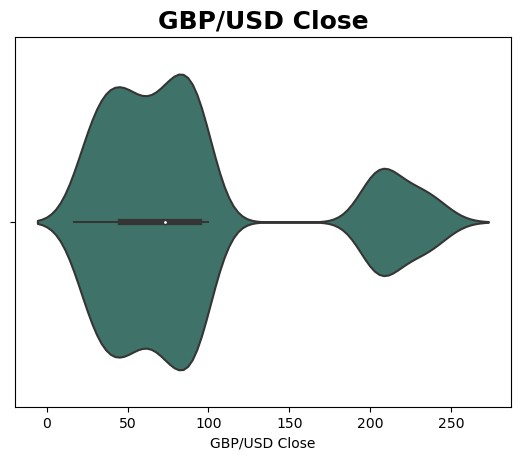

In [ ]:
# for loop
for f in df.columns:
    sns.violinplot(data=df, x= f, s= 1, color=palette[0])
    plt.title( f, fontsize= 18, fontweight= 'bold')
    plt.show()

In [ ]:
df.columns

Index(['GBP/USD Close'], dtype='object')

Price action analysis

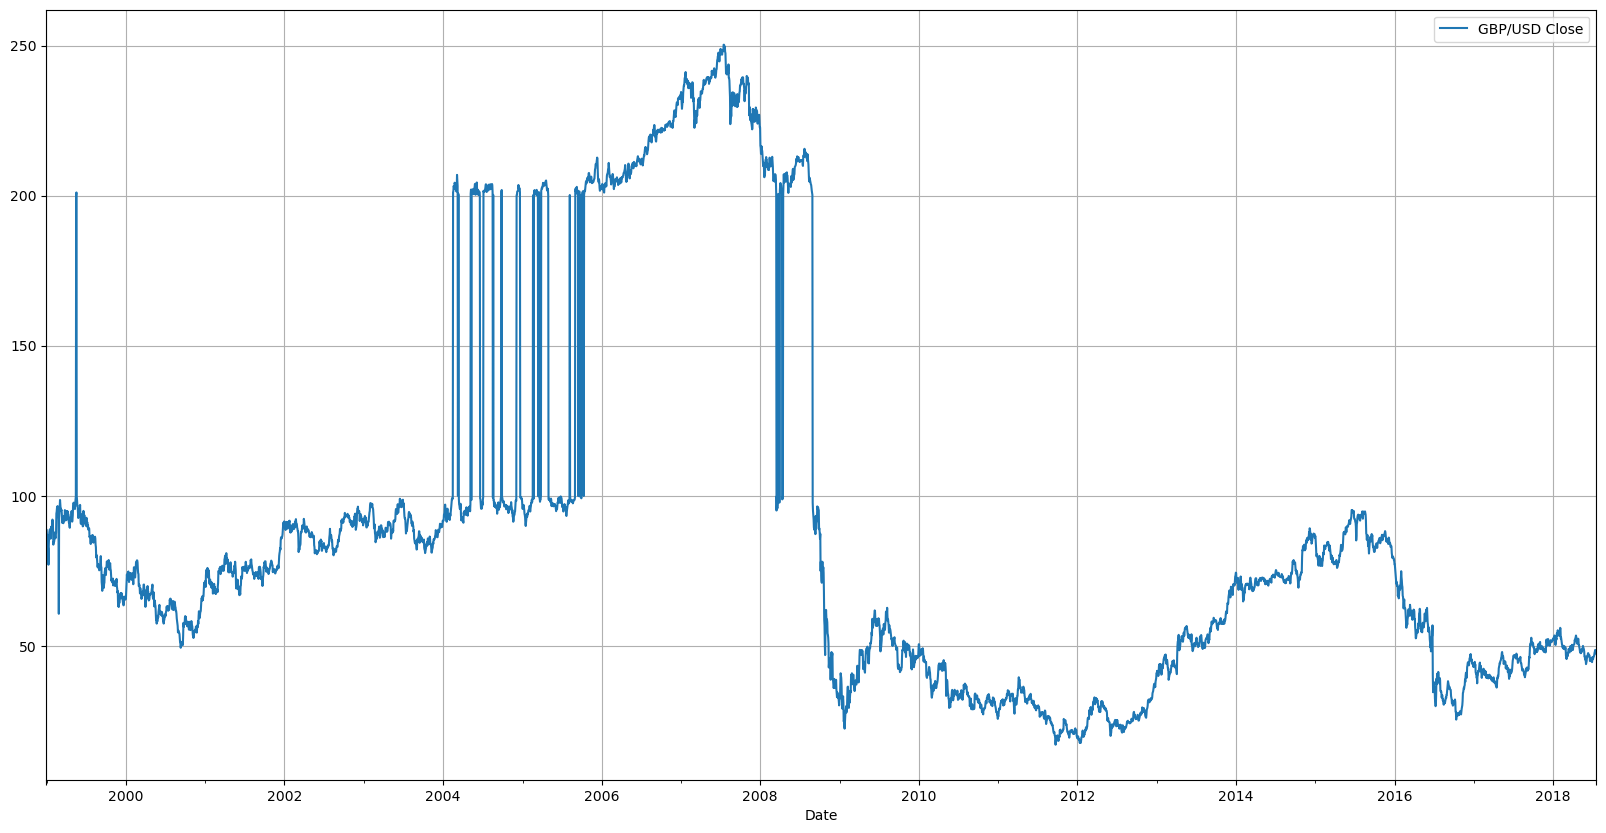

In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib
matplotlib.rc("figure",figsize = (20,10))
df.plot(grid='k')
plt.show()

seasonality

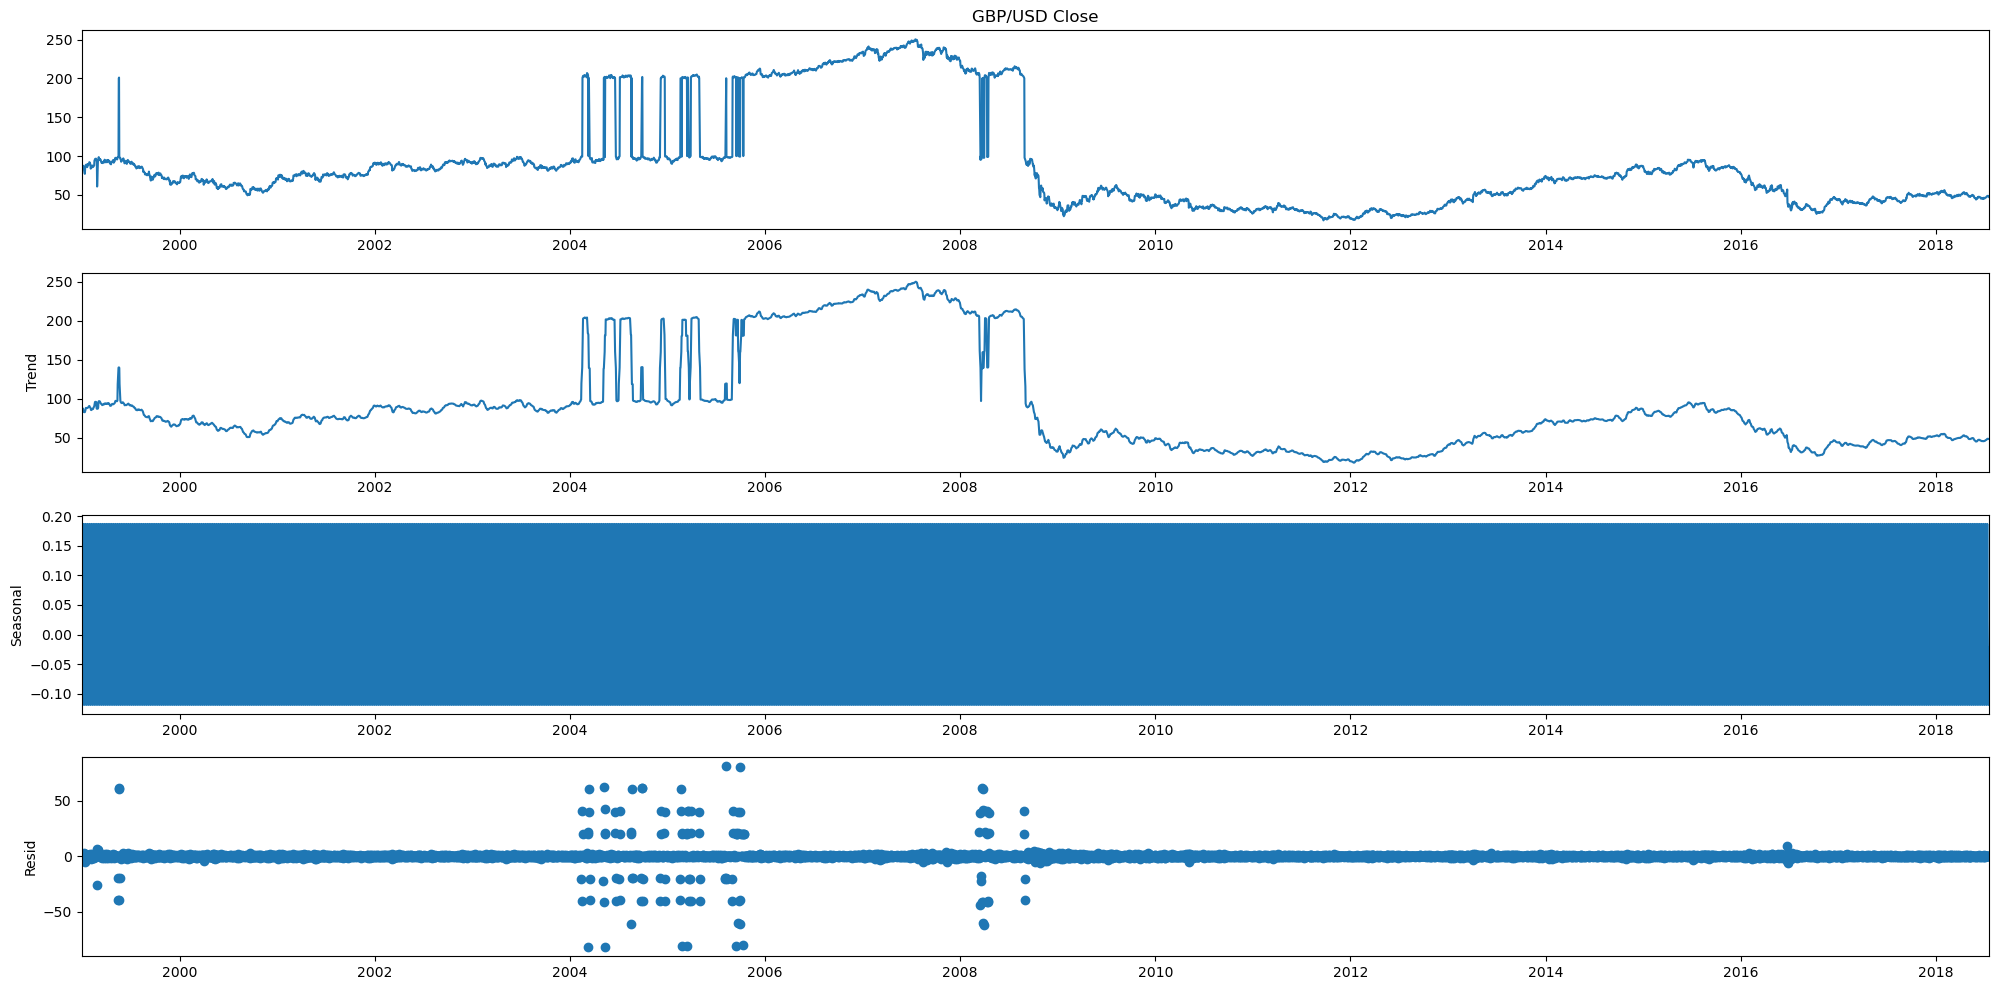

In [ ]:
# seasonal decomposition

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df["GBP/USD Close"],model="additive")
decompose.plot()
plt.show()

Define parameters

In [ ]:
df.index.max()

Timestamp('2018-07-18 00:00:00')

In [ ]:

currency = ['GBP/USD Close']
# Set the start date and the end date
start_date = '2016-07-01'
end_date = '2018-07-18'

List of predictors

In [ ]:
# Create a placeholder to store the currency data

currency_data_dictionary = {}

for currency_pound in currency:

# Calculate the daily percent change
 df['weekly_pct_change'] = df['GBP/USD Close'].pct_change()
# create the predictors
predictor_list = []
for r in range(60, 40, 20):
 df['pct_change_'+str(r)] = df.weekly_pct_change.rolling(r).sum()
 df['std_'+str(r)] = df.weekly_pct_change.rolling(r).std()
predictor_list.append('pct_change_'+ str(r))
predictor_list.append('std_'+str(r))
# Target Variable
df['return_next_week'] = df.weekly_pct_change.shift(-1)
df['actual_signal'] = np.where(df.return_next_week > 0, 1, -1)
df = df.dropna()

currency_data_dictionary.update({currency_pound: df})

Naking Times Series Stationary

<Axes: xlabel='Date', ylabel='weekly_pct_change'>

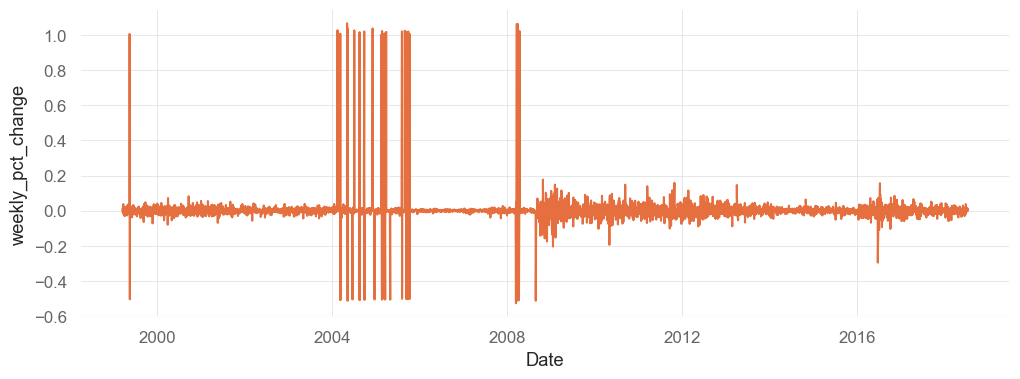

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.lineplot(data=df['weekly_pct_change'], ax=ax , color=palette[4])

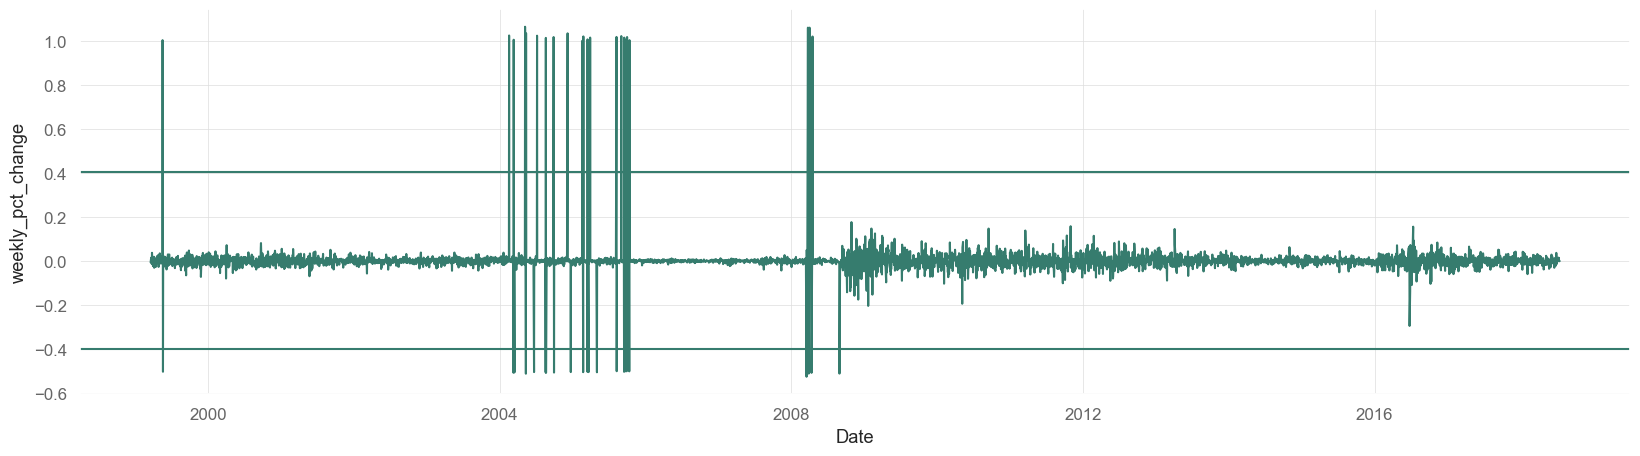

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.lineplot(data=df['weekly_pct_change'], ax=ax , color=palette[0])

std = df['weekly_pct_change'].std()
mn = df['weekly_pct_change'].mean()

upper_limit = mn + (5 * std)
lower_limit = mn - (5 * std)

plt.axhline(upper_limit , color= palette[0])
plt.axhline(lower_limit , color= palette[0])

In [ ]:
plt.style.use('bmh')

Text(0.5, 0, '\n Date\n')

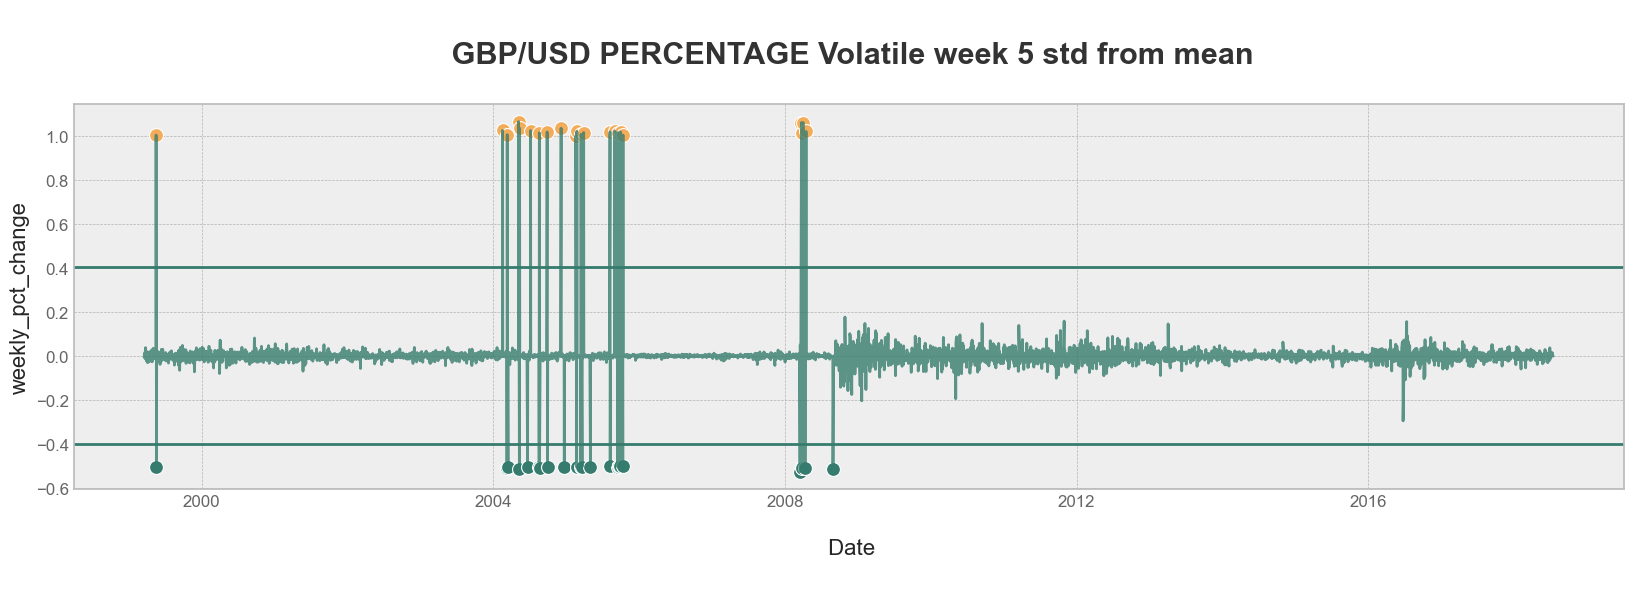

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.lineplot(data=df['weekly_pct_change'], ax=ax , color=palette[0], alpha=.8)

std = df['weekly_pct_change'].std()
mn = df['weekly_pct_change'].mean()

upper_limit = mn + (5 * std)
lower_limit = mn - (5 * std)

plt.axhline(upper_limit , color= palette[0])
plt.axhline(lower_limit , color= palette[0])

sns.scatterplot(data=df[(df['weekly_pct_change'] < lower_limit)]['weekly_pct_change'],
color=palette[0], ax =ax, s=100)

sns.scatterplot(data=df[(df['weekly_pct_change'] > upper_limit)]['weekly_pct_change'],
color=palette[2], ax =ax, s=100)

plt .title('\n GBP/USD PERCENTAGE Volatile week 5 std from mean\n ', fontsize=22, fontweight='bold')
plt. xlabel('\n Date\n', fontsize=16)

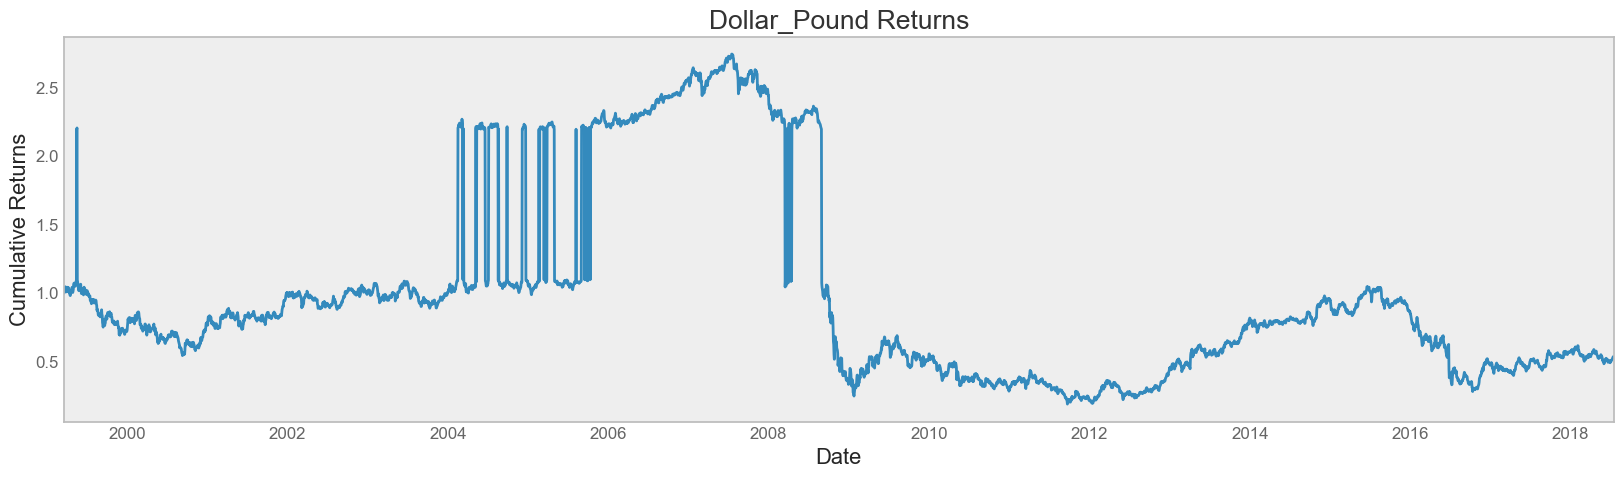

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 5))
# Access the dataframe of AAPL from the dictionary
# and then compute and plot the returns
(currency_data_dictionary['GBP/USD Close'].weekly_pct_change + 1).cumprod().plot()
# Set the title and axis labels and plot grid
plt.title('Dollar_Pound Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

SPLIT the data into train and test

In [ ]:
# Create a placeholder for the train and test split data

train = df.loc[df.index > '2016-01-01']
test = df.loc[df.index >= '2018-07-18']

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
for currency_pound in currency:
# Get predictor variables
 X = currency_data_dictionary[currency_pound][predictor_list]
# Get the target variable
 y = currency_data_dictionary[currency_pound].actual_signal
# Divide the dataset into train and test
train_length = int(len(X)*0.80)
X_train = X_train.append(X[:train_length])
X_test = X_test.append(X[train_length:])
y_train = y_train.append(y[:train_length])
y_test = y_test.append(y[train_length:])

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
# Initialize the model and set the hyperparameter values
from xgboost import Booster


model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
gamma=0, learning_rate=0.1, max_delta_step=0, min_child_weight=1,n_jobs=1, nthread=None, random_state=0,
reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=1, verbosity=1, max_depth= 2, n_estimators=100)
model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=2, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

Cross Validation

In [ ]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5 , shuffle=True, random_state=0)
results = cross_val_score( model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 49.37% (1.04%)


Train the Model

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=2, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=1,
              nthread=None, num_parallel_tree=None, predictor=None, ...)

Feature importance

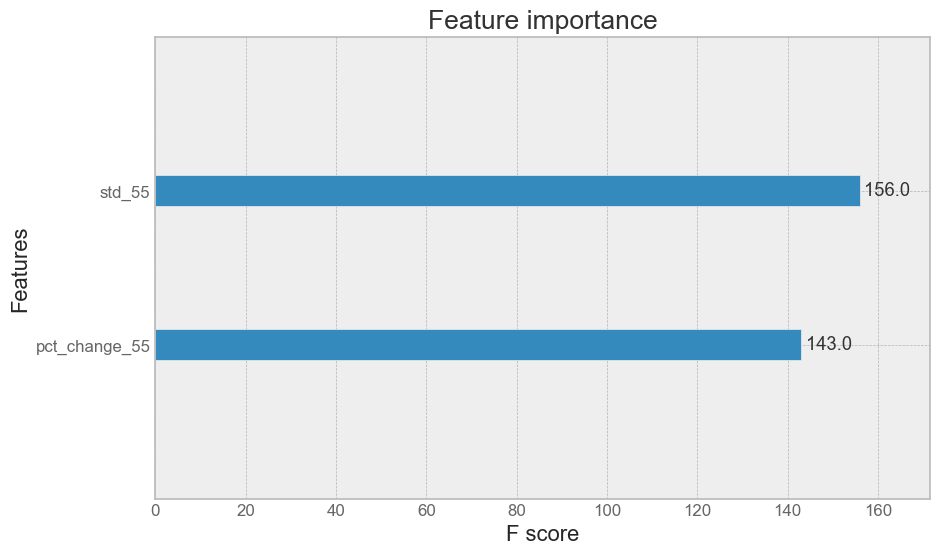

In [ ]:
# plot the top 7 features
xgboost.plot_importance(model, max_num_features=10)
# show the plot
plt.show()

Predict and Classification report
# Predict the trading signal on test dataset

In [ ]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       494
           0       0.00      0.00      0.00         0
           1       0.50      0.75      0.60       515

    accuracy                           0.38      1009
   macro avg       0.17      0.25      0.20      1009
weighted avg       0.26      0.38      0.31      1009



Confusion Matrix

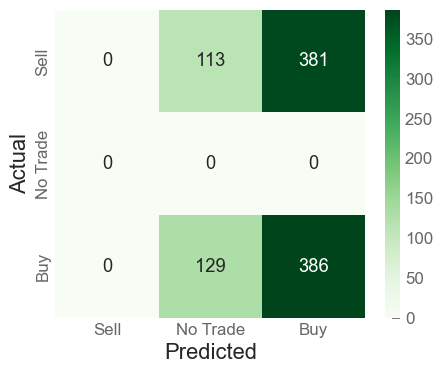

In [ ]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Sell','No Trade' ,'Buy'], columns=['Sell','No Trade' ,'Buy'])
plt.figure(figsize=(5 ,4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(X_test)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)


[[113 381]
 [129 386]]


0.49454905847373637

currency performance

['GBP/USD Close']


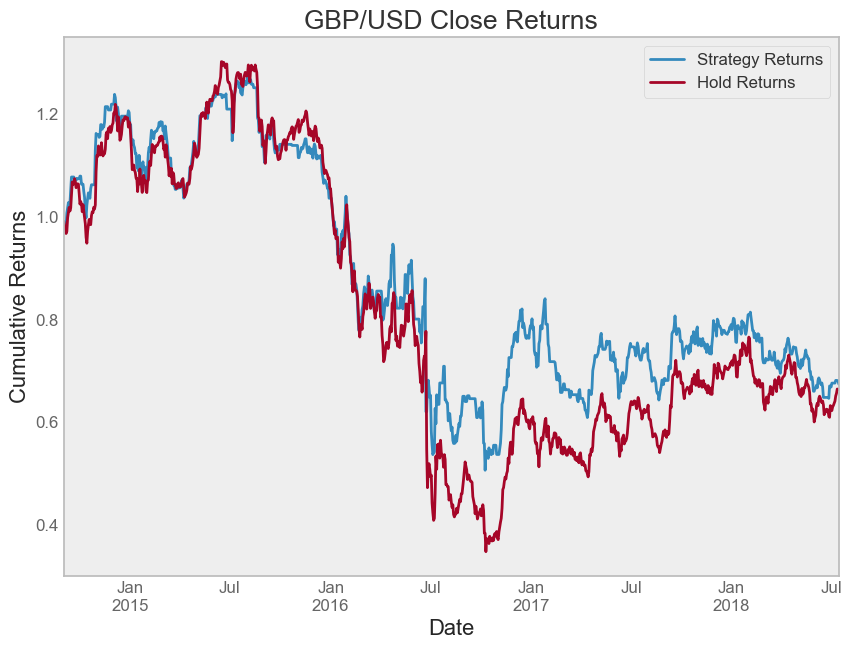

In [ ]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=currency)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for currency_pound in currency:
# Get the data
 df = currency_data_dictionary[currency_pound]
# Store the predictor variables in X
X = df[predictor_list]
# Define the train and test dataset
train_length = int(len(X)*0.80)
# Predict the signal and store in predicted signal column
df['predicted_signal'] = model.predict(X)
# Calculate the strategy returns
df['strategy_returns'] = df.return_next_week * df.predicted_signal
# Add the strategy returns to the portfolio dataframe
portfolio[currency_pound] = df.strategy_returns[train_length:]
# Plot the stock strategy and buy and hold returns
print(currency)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative strategy returns and plot
(df.strategy_returns[train_length:]+1).cumprod().plot()
# Calculate the cumulative buy and hold strategy returns
(currency_data_dictionary[currency_pound][train_length:].weekly_pct_change+1).cumprod().plot()
# Set the title, label and grid
plt.title(currency_pound + ' Returns')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Strategy Returns', 'Hold Returns'])
plt.grid()
plt.show()

Currency Trade

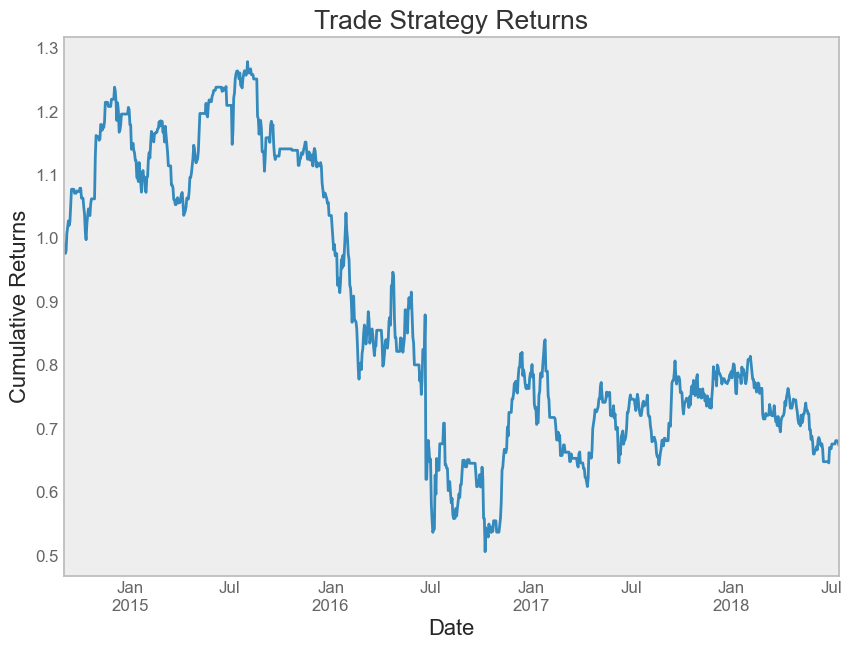

In [ ]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Trade Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [ ]:
import quantstats as qs


                           Strategy
-------------------------  ----------
Start Period               2014-09-03
End Period                 2018-07-16
Risk-Free Rate             0.0%
Time in Market             76.0%

Cumulative Return          -32.6%
CAGR﹪                     -9.7%

Sharpe                     -0.11
Prob. Sharpe Ratio         41.42%
Smart Sharpe               -0.1
Sortino                    -0.14
Smart Sortino              -0.14
Sortino/√2                 -0.1
Smart Sortino/√2           -0.1
Omega                      0.98

Max Drawdown               -60.42%
Longest DD Days            1076
Volatility (ann.)          34.36%
Calmar                     -0.16
Skew                       -2.23
Kurtosis                   38.85

Expected Daily %           -0.04%
Expected Monthly %         -0.84%
Expected Yearly %          -7.59%
Kelly Criterion            -1.22%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.57%
Expected Shortfall (cVaR)  -3.57%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-08-05,2016-10-10,2018-07-16,1076,-60.416158,-57.925423
2,2014-12-05,2015-04-09,2015-06-25,202,-16.323281,-15.763534
3,2014-10-06,2014-10-14,2014-10-30,24,-7.529935,-6.415581
4,2015-06-26,2015-07-07,2015-07-13,17,-7.361200,-5.719842
5,2015-07-17,2015-07-24,2015-07-29,12,-2.123799,-1.910352


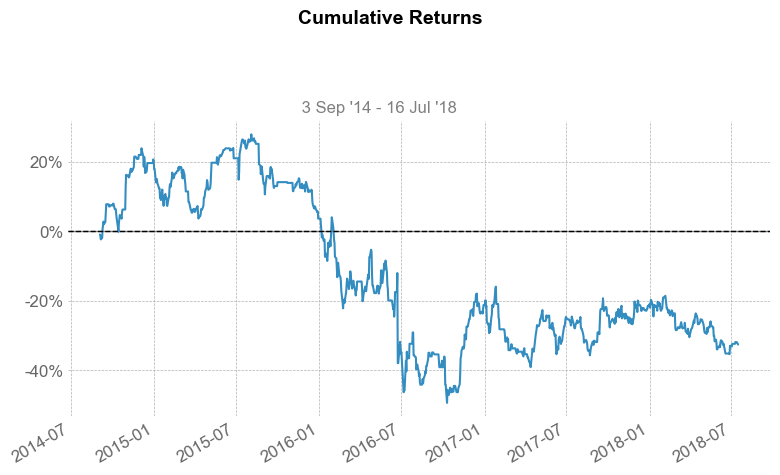

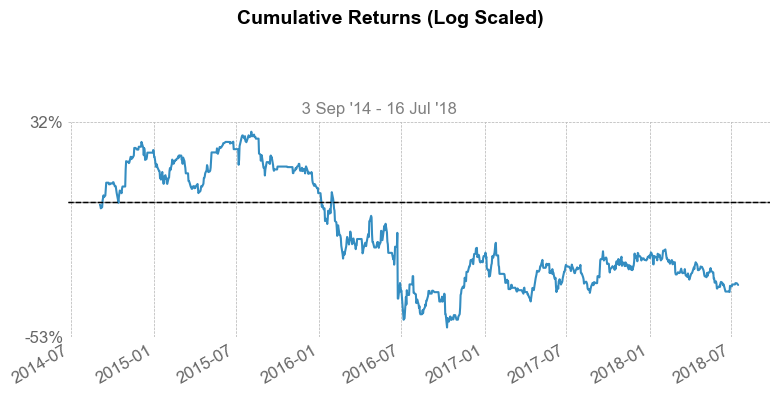

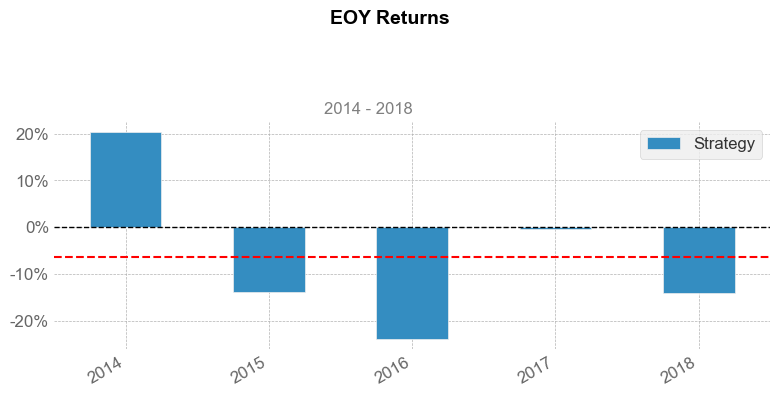

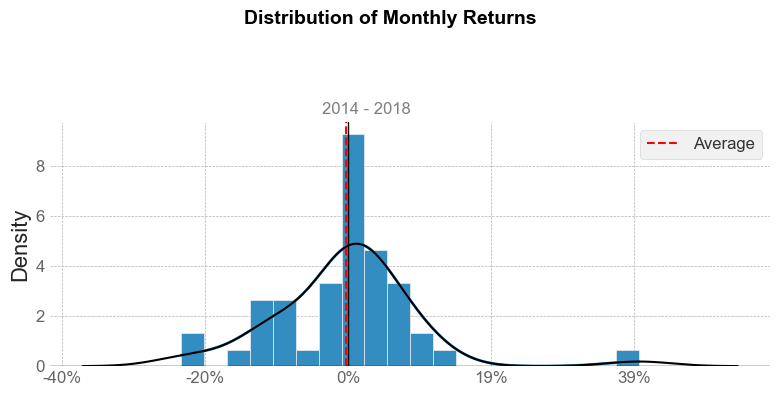

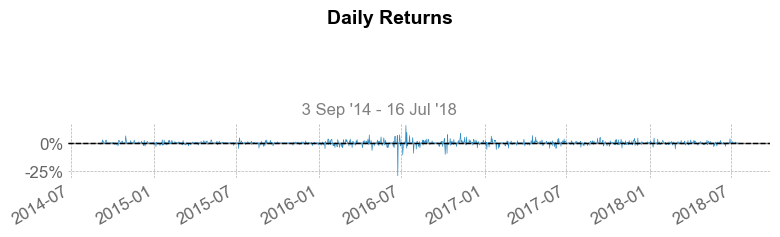

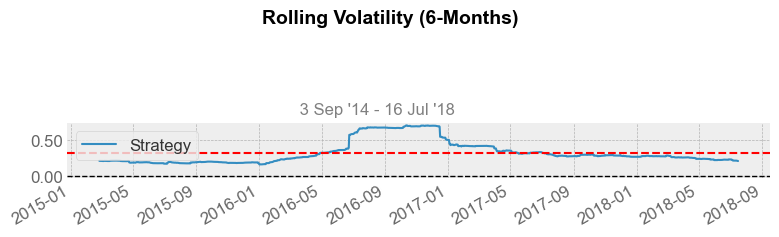

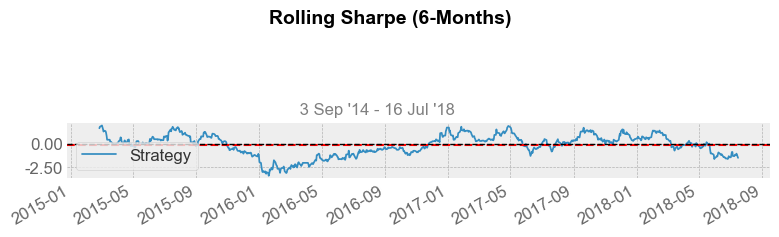

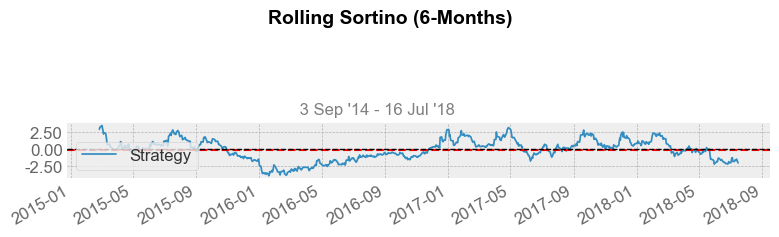

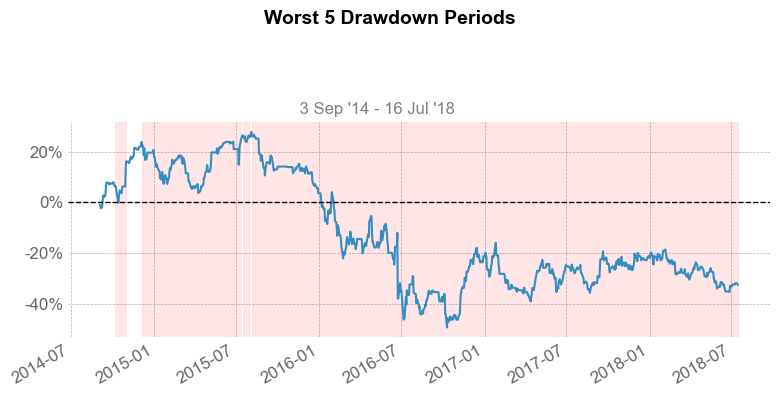

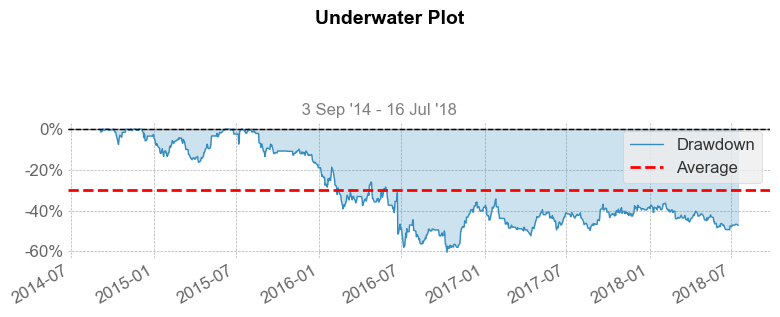

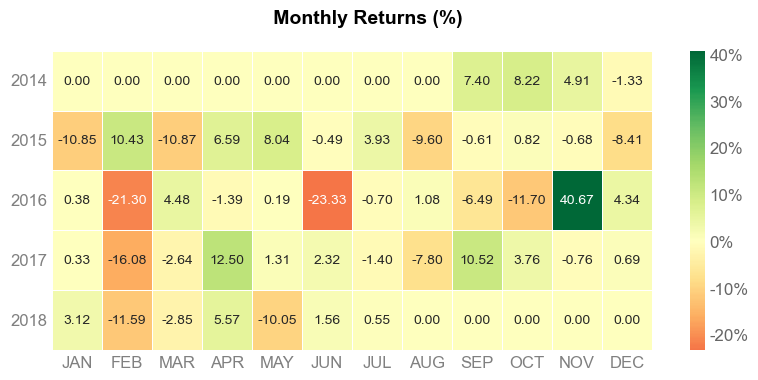

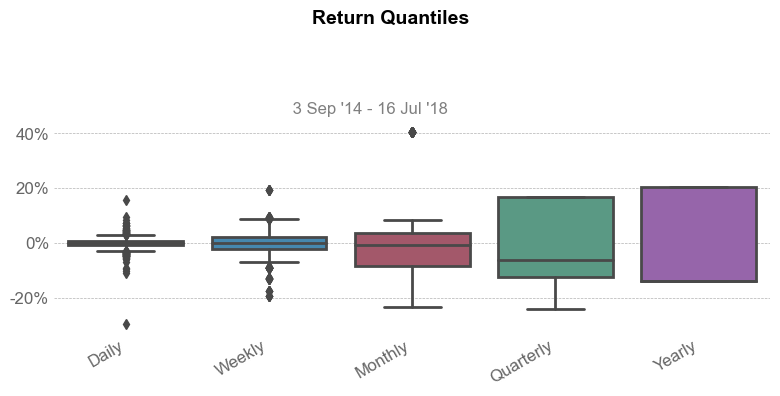

In [ ]:
qs.reports.full(portfolio.mean( axis=1))